# Tutorial 7: Autoencoders

## Prerequisites
1. Tensorflow
2. Scikit Learn
3. Matplotlib

## Topics covered
1. Building Deep Autoencoder in Tensorflow
2. Regularizations
3. Variational Autoencoders

## Building Deep Autoencoder
- We will build an Autoencoder
- Will train it on MNIST dataset
- And visualize how it performs and compare it with PCA.

![AE Model](./images/aemodel.png)

**Specifications**

1. Three hidden layers
2. Reduction is `784 > 512 > 256 > 64`
3. Weights are shared among encoder and decoder but biases are not shared

**STEP 1: Load dataset and libraries**

Note: It can take some time to download MNIST dataset from 	`sklearn.datasets`

In [1]:
!nvidia-smi

Thu Mar  2 17:46:11 2017       
+------------------------------------------------------+                       
| NVIDIA-SMI 352.93     Driver Version: 352.93         |                       
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 0000:05:00.0     Off |                    0 |
| N/A   30C    P8    26W / 149W |     55MiB / 11519MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 0000:06:00.0     Off |                    0 |
| N/A   36C    P8    27W / 149W |     55MiB / 11519MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'

import numpy as np

from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST Original')
data = mnist.data/255.
mnist.data.shape

(70000, 784)

**STEP 2: Create autoencoder model**

In [7]:
import tensorflow as tf

def autoencoder(layer_sizes=[784, 512, 256, 64]):
    """
    Input:
        layer_sizes: Number of neurons in encoding model of AE
    Output:
        Dictionary of input tensor (x), encoded layer tensor (z), 
        output layer tensor (y) and cost function (cost)
    """
    x = tf.placeholder(tf.float32, [None, layer_sizes[0]])
    
    ae = {'x': x}
    
    pl = x
    encoder_weights = []
    for i, ls in enumerate(layer_sizes[1:]):
        
        w = tf.Variable(tf.random_uniform([layer_sizes[i], ls], 
                                     -1./np.sqrt(layer_sizes[i]), 1./np.sqrt(layer_sizes[i])))
        encoder_weights.append(w)
        b = tf.Variable(tf.zeros([ls]))
        pl = tf.sigmoid(tf.matmul(pl, w) + b)
    
    ae['z'] = pl
    
    for w, ls in zip(reversed(encoder_weights), reversed(layer_sizes[:-1])):
        
        b = tf.Variable(tf.zeros([ls]))
        pl = tf.sigmoid(tf.matmul(pl, tf.transpose(w)) + b)
        
    ae['y'] = pl
    
    cost = tf.reduce_mean(tf.square(ae['x'] - ae['y']))
    ae['cost'] = cost
    
    return ae

**STEP 3: Train the network**

For each epoch:
1. Shuffle dataset
2. Select a batch
3. Train network with selected batch
4. Continue until all batches are finished
5. Repeat with next epoch

In [8]:
tf.reset_default_graph()

#sess.close()
sess = tf.InteractiveSession()

ae = autoencoder()

grad_op = tf.train.AdamOptimizer().minimize(ae['cost'])
init = tf.global_variables_initializer()
sess.run(init)

In [9]:
def run_epochs(n_epoch=10, batch_size=32):
    
    n_batch = int(len(data)/batch_size)
    
    for i_epoch in range(n_epoch):

        indexes = np.arange(len(data))
        np.random.shuffle(indexes)

        batch_costs = []
        
        for i_batch in range(n_batch):

            sindx = indexes[i_batch*batch_size:(i_batch+1)*batch_size]
            
            c, _ = sess.run([ae['cost'], grad_op], feed_dict={
                ae['x']: data[sindx]
            })
            
            batch_costs.append(c)
            
        print 'Epoch %i, Average Loss: %f' % (i_epoch, np.mean(batch_costs))

In [10]:
run_epochs(20, 100)

Epoch 0, Average Loss: 0.068499
Epoch 1, Average Loss: 0.057652
Epoch 2, Average Loss: 0.043965
Epoch 3, Average Loss: 0.032331
Epoch 4, Average Loss: 0.027659
Epoch 5, Average Loss: 0.024903
Epoch 6, Average Loss: 0.022561
Epoch 7, Average Loss: 0.020666
Epoch 8, Average Loss: 0.019247
Epoch 9, Average Loss: 0.018190
Epoch 10, Average Loss: 0.017330
Epoch 11, Average Loss: 0.016530
Epoch 12, Average Loss: 0.015797
Epoch 13, Average Loss: 0.015164
Epoch 14, Average Loss: 0.014563
Epoch 15, Average Loss: 0.013990
Epoch 16, Average Loss: 0.013468
Epoch 17, Average Loss: 0.012975
Epoch 18, Average Loss: 0.012517
Epoch 19, Average Loss: 0.012115


**STEP 4: How well can we reconstruct?**

(-0.5, 27.5, 27.5, -0.5)

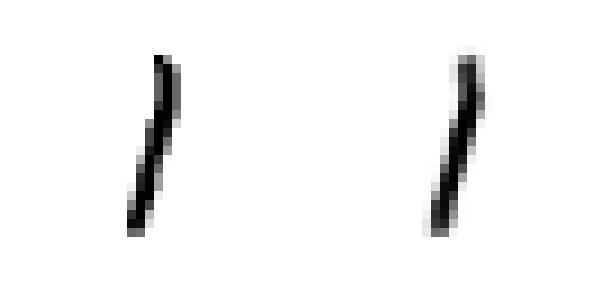

In [22]:
rec_ae = sess.run(ae['y'], feed_dict={ae['x']: data})

idx = np.random.randint(len(rec_ae))

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(1. - data[idx].reshape(28, 28))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(1. - rec_ae[idx].reshape(28, 28))
plt.axis('off')

### PCA vs Autoencoder

Lets apply PCA and get 64 principle components.

In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components=64)
rec_lc = pca.fit_transform(data)

In [24]:
rec_pca = []
for lc in rec_lc:
    fc = np.zeros(pca.components_.shape[1])
    for c, l in zip(pca.components_, lc):
        fc += l*c
    rec_pca.append(fc)

In [26]:
rec_pca = np.array(rec_pca)
rec_pca.shape

(70000, 784)

(-0.5, 27.5, 27.5, -0.5)

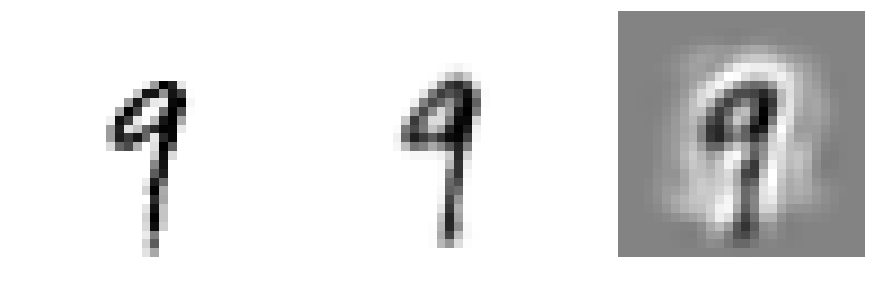

In [37]:
rec_ae = sess.run(ae['y'], feed_dict={ae['x']: data})

idx = np.random.randint(len(rec_ae))

plt.figure(figsize=(15, 10))

plt.subplot(1, 3, 1)
plt.imshow(1. - data[idx].reshape(28, 28))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(1. - rec_ae[idx].reshape(28, 28))
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(1. - rec_pca[idx].reshape(28, 28))
plt.axis('off')

**Exercise 1: ~10 minutes**
1. Visualize `rec_lc` and `ae['z']` using TSNE.
2. Use only randomly selected 2000 datapoints.

In [38]:
from sklearn.manifold import TSNE

indx = np.arange(len(data))
np.random.shuffle(indx)
indx = indx[:2000]

tsne1 = TSNE(n_components=2, verbose=True)
tsne2 = TSNE(n_components=2, verbose=True)

X1 = tsne1.fit_transform(rec_lc[indx])

rec_z = sess.run(ae['z'], feed_dict={ae['x']: data})
X2 = tsne2.fit_transform(rec_z[indx])

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 2.372133
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.267761
[t-SNE] Error after 150 iterations: 1.267761
[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.677113
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.260871
[t-SNE] Error after 125 iterations: 1.260871


/home/s6kalra/pyenvs/gpu/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


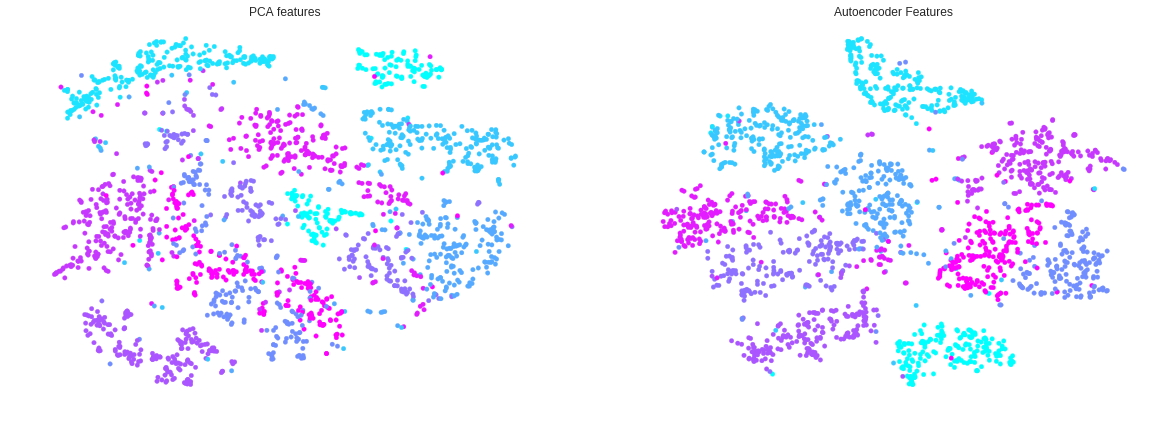

In [39]:
import seaborn
plt.figure(figsize=(20, 7))

plt.subplot(1, 2, 1)
plt.scatter(X1[:, 0], X1[:, 1], s=20, c=mnist.target[indx], cmap=plt.cm.cool)
plt.title('PCA features')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.scatter(X2[:, 0], X2[:, 1], s=20, c=mnist.target[indx], cmap=plt.cm.cool)
plt.axis('off')
plt.title('Autoencoder Features')
_dummy = 1.

## Variational Autoencoder

![VAE](images/vae.png)
Reference: http://blog.fastforwardlabs.com/2016/08/22/under-the-hood-of-the-variational-autoencoder-in.html

Same as Autoencoder but deepest layer is regularized to follow Gaussian distribution. For more details see above reference.

**STEP 1: Load libraries**

VAE code is taken from: https://jmetzen.github.io/2015-11-27/vae.html

Load it from `libs/tut7.py`

In [40]:
from libs import tut7

network_architecture = dict(
    n_hidden_recog_1=500,
    n_hidden_recog_2=500,
    n_hidden_gener_1=500,
    n_hidden_gener_2=500,
    n_input=784,
    n_z=2)

In [41]:
tf.reset_default_graph()
batch_size = 100
vae = tut7.VariationalAutoencoder(
    network_architecture, learning_rate=0.001, batch_size=100)

In [42]:
def run_vae_epochs(n_epoch=10, batch_size=batch_size):
    
    n_batch = int(len(data)/batch_size)
    
    for i_epoch in range(n_epoch):

        indexes = np.arange(len(data))
        np.random.shuffle(indexes)

        batch_costs = []
        
        for i_batch in range(n_batch):

            sindx = indexes[i_batch*batch_size:(i_batch+1)*batch_size]
            
            cost = vae.partial_fit(data[sindx])
            
            batch_costs.append(cost)
            
        print 'Epoch %i, Average Loss: %f' % (i_epoch, np.mean(batch_costs))

**STEP 2: Train VAE**

In [43]:
run_vae_epochs(10)

Epoch 0, Average Loss: 183.963516
Epoch 1, Average Loss: 164.370697
Epoch 2, Average Loss: 158.957718
Epoch 3, Average Loss: 155.685883
Epoch 4, Average Loss: 153.402435
Epoch 5, Average Loss: 151.630096
Epoch 6, Average Loss: 150.113922
Epoch 7, Average Loss: 148.951447
Epoch 8, Average Loss: 147.996445
Epoch 9, Average Loss: 147.190643


**STEP 3: How well can we reconstruct?**

In [44]:
rec_vae = []

for i in np.arange(0, len(data), batch_size):
    rec_vae.extend(vae.reconstruct(data[i:i+batch_size]))
    
rec_vae = np.array(rec_vae)

(-0.5, 27.5, 27.5, -0.5)

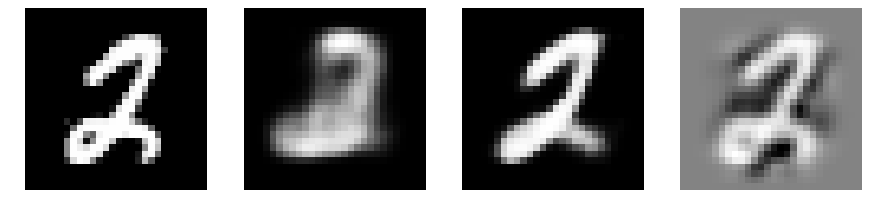

In [46]:
idx = np.random.randint(len(rec_vae))

plt.figure(figsize=(15, 10))

plt.subplot(1, 4, 1)
plt.imshow(data[idx].reshape(28, 28))
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(rec_vae[idx].reshape(28, 28))
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(rec_ae[idx].reshape(28, 28))
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(rec_pca[idx].reshape(28, 28))
plt.axis('off')

### Visualizing latent space

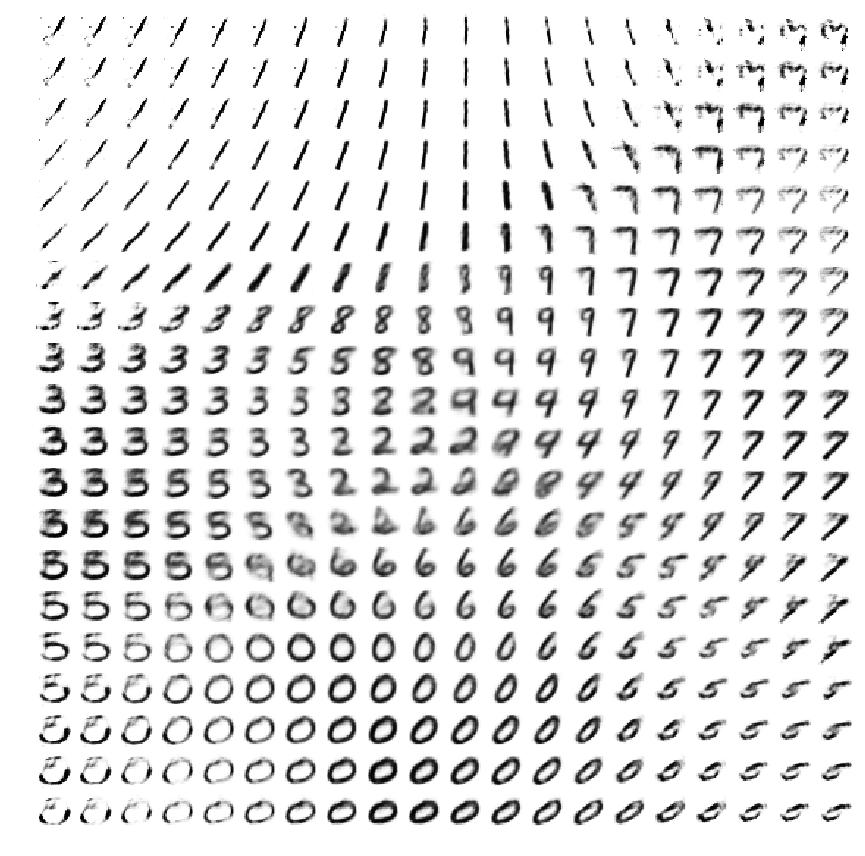

In [89]:
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

canvas = np.ones((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]]*vae.batch_size)
        x_mean = vae.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = 1. - x_mean[0].reshape(28, 28)

plt.figure(figsize=(12, 12))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.axis('off')
plt.tight_layout()

### Latent vector arithmetic

Taken from: http://blog.otoro.net/2016/04/01/generating-large-images-from-latent-vectors/

In [52]:
def encode_to_z(x):
    return vae.transform([x]*vae.batch_size)[0]

def z_to_image(z):
    return vae.generate([z]*vae.batch_size)[0]

def show(x):
    plt.imshow(x.reshape(28, 28))
    plt.axis('off')
    
def get_rand_digit(digit):
    wh_idx = np.where(mnist.target == digit)[0]
    return wh_idx[np.random.randint(len(wh_idx))]


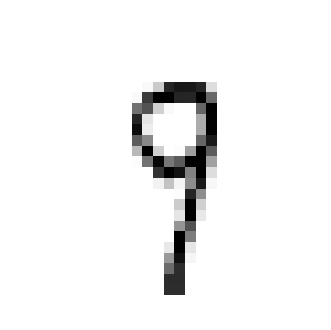

In [54]:
idx = get_rand_digit(9)
show(data[idx])

z9 = encode_to_z(data[idx])

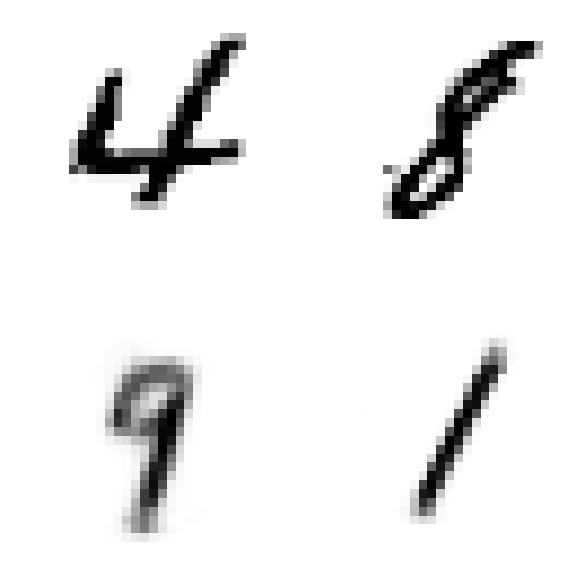

In [56]:
idx1, idx2 = get_rand_digit(4), get_rand_digit(8)

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
show(data[idx1])
z11 = encode_to_z(data[idx1])

plt.subplot(2, 2, 2)
show(data[idx2])
z12 = encode_to_z(data[idx2])

plt.subplot(2, 2, 3)
show(z_to_image(z9))

plt.subplot(2, 2, 4)
new_z = z9 + 0.85*(z12 - z11)
show(z_to_image(new_z))